In [2]:
import pandas as pd #For reading dataset files
import networkx as nx #For network creation/analysis
from networkx.algorithms import community
import community as community_louvain
import matplotlib.pyplot as plt #For plotting graphs
import igraph as ig
import numpy as np
import leidenalg as la
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    f1_score,
    confusion_matrix,
)
from collections import Counter
from networkx.algorithms.community import label_propagation_communities
from cdlib import algorithms

from modularitydensity.metrics import modularity_density
import community as louvain
import leidenalg as la
from cdlib.algorithms import louvain

from cdlib import evaluation

import os

import random


np.random.seed(42)  # Imposta il seed per NumPy
random.seed(42)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'infomap', 'graph_tool', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


# Login dataset

Comunità con gt=0: ['100monkeystyping.com', '12thharmonic.com/wordpress', '750volts.blogspot.com', '95theses.blogspot.com', 'abbadabbaduo.blogspot.com', 'aboutpolitics.blogspot.com', 'achingandspinning.blogspot.com', 'ackackack.com', 'adamtalib.blogspot.com', 'adviceforlefty.blogspot.com', 'agonist.org', 'aintnobaddude.com', 'ajbenjaminjr.blogspot.com', 'alicublog.blogspot.com', 'allanjenkins.typepad.com', 'allspinzone.blogspot.com', 'alphapredator.com/wdtgw.htm', 'alternateworlds.blogspot.com', 'althippo.blogspot.com', 'alvintostig.typepad.com', 'americablog.blogspot.com', 'americablog.org', 'americanmuslim.blogs.com', 'americanpolitics.com', 'americansforbayh.blogspot.com', 'amleft.blogspot.com', 'amliberal.com/blog', 'amptoons.com/blog', 'anarchyxero.robfindlay.org', 'andifeelfine.blogspot.com', 'andymatic.com', 'angrybear.blogspot.com', 'angrydesi.typepad.com', 'angryfinger.org', 'angryhomo.blogspot.com', 'annatopia.com/home.html', 'anoldsoul.blogspot.com', 'anonymoussources.blogsp

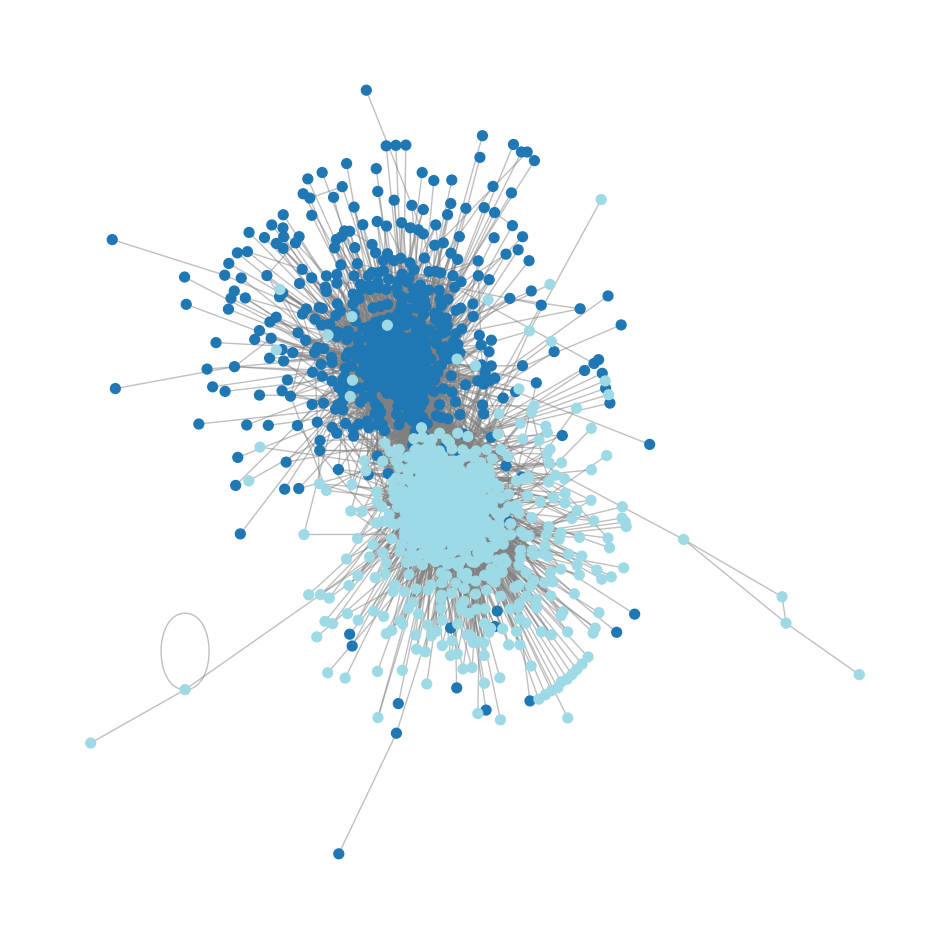

In [3]:
# Percorso del file GML
file_path = "C:/Users/lulyd/Downloads/polblogs.gml"

# Leggi il grafo dal file GML
G = nx.read_gml(file_path)

# Variabile globale per memorizzare le comunità di ground truth
communities_dict = {}

# Itera su tutti i nodi del grafo
for node in G.nodes(data=True):
    node_id = node[0]   # id del nodo
    gt_value = node[1].get('gt')  # il valore di ground truth (gt)

    # Aggiungi il nodo alla comunità corrispondente
    if gt_value in communities_dict:
        communities_dict[gt_value].append(node_id)
    else:
        communities_dict[gt_value] = [node_id]

# Stampa le comunità
for gt, nodes in communities_dict.items():
    print(f"Comunità con gt={gt}: {nodes}")

# Ottieni i valori gt per colorare i nodi
gt_values = nx.get_node_attributes(G, 'gt')

# Crea una mappa di colori basata sui membri della comunità
color_map = []
for node in G.nodes():
    # Assegna un ID di comunità a ciascun nodo
    found = False
    for department, members in communities_dict.items():
        if node in members:
            color_map.append(department)  # Colore della comunità
            found = True
            break
    if not found:
        color_map.append('lightgray')  # Colore per nodi non appartenenti a nessuna comunità

# Disegna il grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)  # Posizioni per tutti i nodi

# Disegna gli archi in grigio
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')

# Disegna i nodi con la mappa di colori
unique_departments = list(set(color_map))
cmap = plt.cm.get_cmap('tab20', len(unique_departments))

# Assegna un colore ai nodi in base alla comunità
node_colors = [cmap(unique_departments.index(c)) for c in color_map]

# Disegna i nodi
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors)

# Opzionale: Disegna le etichette dei nodi se necessario
# nx.draw_networkx_labels(G, pos, font_size=10)

plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra il grafo


In [19]:
def calcola_metriche(comunita_attese, comunita_rilevate, adjacency_matrix):
    # Creazione della mappatura dei nodi a indici
    nodi = []
    for community in comunita_attese.values():
        nodi.extend(community)
    nodo_to_index = {nodo: idx for idx, nodo in enumerate(nodi)}

    # Preparazione dei dati per ARI e NMI
    true_labels = np.zeros(len(nodi), dtype=int)  # Etichette vere
    for community_id, community_nodes in comunita_attese.items():
        for node in community_nodes:
            true_labels[nodo_to_index[node]] = int(community_id[-1])  # Usa l'ID della comunità

    predicted_labels = np.full(len(nodi), -1)  # Valori non assegnati    
    for cluster_id, nodes in comunita_rilevate.items():
        for node in nodes:
            if node in nodo_to_index:  # Assicurati che il nodo esista nella mappatura
                predicted_labels[nodo_to_index[node]] = int(cluster_id)  # Usa l'ID della comunità

# Calcolo delle metriche
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    # Calcolo dell'HS
    hs = homogeneity_score(true_labels, predicted_labels)

    # Calcolo del CS
    cs = completeness_score(true_labels, predicted_labels)

    # Calcolo della F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calcolo della Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Calcolo della Modularity Density
    md = modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Score
    cs_score = community_score(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Fitness
    fitness = community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index)


    # Stampa dei risultati
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
    print(f"Homogeneity Score (HS): {hs:.4f}")
    print(f"Completeness Score (CS): {cs:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Modularity Density: {md:.4f}")
    print(f"Community Score: {cs_score:.4f}")
    print(f"Community Fitness: {fitness:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Risultati da visualizzare
    metriche = {
        'ARI': ari,
        'AMI': ami,
        'HS': hs,
        'CS': cs,
        'F1 Score': f1,
        'Modularity Density': md,
        'Community Score': cs_score,
        'Community Fitness': fitness,
        'NMI': nmi
    }

    return metriche

    # Creazione del grafico a barre
    plt.figure(figsize=(10, 6))
    plt.bar(metriche.keys(), metriche.values(), color='skyblue')
    plt.ylabel('Valore')
    plt.title('Metriche di Rilevamento delle Comunità')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

 

    x = np.arange(len(labels))
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, true_values, width=bar_width, label='Comunità Attese', color='skyblue')
    plt.bar(x + bar_width/2, predicted_values, width=bar_width, label='Comunità Rilevate', color='salmon')
    plt.xlabel('Comunità')
    plt.ylabel('Numero di Nodi')
    plt.title('Confronto tra Comunità Attese e Rilevate')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    
# Funzioni di supporto 
def modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index):
    k = len(comunita_rilevate)  # Numero di comunità
    densita = 0.0  # Inizializza la densità a zero

    for community in comunita_rilevate.values():
        V_c = len(community)  # Numero di nodi nella comunità
        E_c = 0  # Inizializza il conteggio degli archi nella comunità

        # Calcola il numero di archi tra i nodi nella comunità
        for i in range(V_c):
            for j in range(i + 1, V_c):  # Evita il conteggio doppio
                idx_i = nodo_to_index[community[i]]
                idx_j = nodo_to_index[community[j]]
                if adjacency_matrix[idx_i, idx_j] > 0:
                    E_c += 1

        # Calcola la densità della comunità
        if V_c > 1:  # Evita divisioni per zero
            densita += E_c / (V_c * (V_c - 1))

    # Calcola la densità modulare finale
    if k > 0:  # Evita divisioni per zero
        densita_modulare = densita / k
    else:
        densita_modulare = 0

    return densita_modulare

def community_score(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    total_edges = 0
    num_nodes = adjacency_matrix.shape[0]

    for community in comunita_rilevate.values():
        for i in range(len(community)):
            for j in range(i + 1, len(community)):  # Per evitare il conteggio doppio
                node_i = community[i]
                node_j = community[j]
                if adjacency_matrix[nodo_to_index[node_i], nodo_to_index[node_j]] > 0:
                    internal_edges += 1
    
    # Conta anche gli archi totali nel grafo
    total_edges = np.sum(adjacency_matrix) / 2  # Dato che è una matrice simmetrica

    if total_edges == 0:
        return 0  # Evita divisioni per zero
    return internal_edges / total_edges


def community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    external_edges = 0
    num_nodes = adjacency_matrix.shape[0]  # Assicurati che la matrice sia quadrata

    node_to_community = {}
    for community_id, nodes in comunita_rilevate.items():
        for node in nodes:
            node_to_community[node] = community_id

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] > 0:  # Se esiste un arco
                node_i = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(i)]
                node_j = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(j)]
                if node_to_community.get(node_i) == node_to_community.get(node_j):  # Se appartengono alla stessa comunità
                    internal_edges += 1
                else:
                    external_edges += 1

    total_edges = internal_edges + external_edges

    # Evita divisioni per zero
    if total_edges == 0:
        return 0

    return internal_edges / total_edges

# Label propagation

Community 1: ['mwilliams.info', 'techtrend.com/blog/taranicole', 'theurbangrind.blogspot.com', 'winceandnod.blogspot.com', 'discountblogger.com', 'qoae.net', 'headland.blogspot.com', 'aldaynet.org', 'decision08.blogspot.com', 'prosandcons.us', 'rabner.blogspot.com', 'zeke01.typepad.com', 'freedomofthought.com', 'datingrepublicans.com', 'metallicity.com/mb.asp', 'robertp17.blogspot.com', 'cbcbcbcb.blogspot.com', 'dynamist.com/weblog', 'piano-tuning.net/blog', 'bitheads.blogspot.com', 'regimechangeiran.com', 'billrice.org', 'celluloid-wisdom.com/pw', 'valuerightnews.blogspot.com', 'punditguy.com', 'watchandwait.blogspot.com', 'blogspirator.blogspot.com', 'nationalreview.com/thecorner/corner.asp', 'conservativecat.com', 'mtvirtus.blogspot.com', 'buzzmachine.com', 'thesakeofargument.com', 'limericksavant.blogspot.com', 'inthebullpen.com', 'tomherod.blogspot.com', 'conservativeresponse.com', 'lashawnbarber.com', 'professorbainbridge.com', 'sondrak.com', 'virginiapolitics.blogspot.com', 'liv

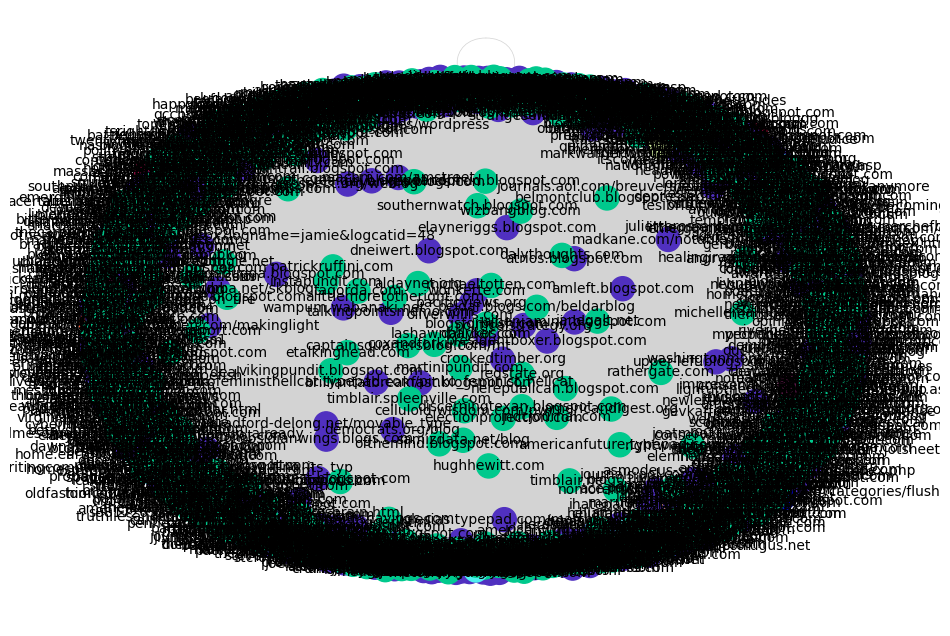

Adjusted Rand Index (ARI): 0.7915
Adjusted Mutual Information (AMI): 0.6808
Homogeneity Score (HS): 0.7365
Completeness Score (CS): 0.6369
F1 Score: 0.0454
Confusion Matrix:
[[ 44 529   0   3   2   2   2   2   2   0   0]
 [615  13   4   0   0   0   0   0   0   2   2]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]
Modularity Density: 0.3828
Community Score: 0.9266
Community Fitness: 0.9267
Normalized Mutual Information (NMI): 0.6831


In [20]:
community_graph = nx.Graph() 
# Rilevamento delle comunità con l'algoritmo Label Propagation
communities= algorithms.label_propagation(G).communities
community_dict_label_propagation = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)


# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", "#F0A500", 'yellow', 'blue', "#FF5733", "#C70039",  "#900C3F", "#581845", "#DAF7A6", "#FFC300"]

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

# Disegna il grafo originale con colori per le comunità
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='lightgray')  # Larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Dimensione delle etichette
plt.axis("off")
plt.show()


adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_label_propagation = calcola_metriche(communities_dict, community_dict_label_propagation, adj_matrix_full)

# Louvain

Community 1: ['adamtalib.blogspot.com', 'buzzmachine.com', 'clarified.blogspot.com', 'elderbearden.blogspot.com', 'estropundit.blogspot.com', 'fuckthisblog.blogspot.com', 'ibe.blogspot.com', 'iwantmycountryback.org', 'jimtreacher.com', 'julietterossant.com/superchefblog/superchefblog.html', 'justmark.com', 'lawdork.blogspot.com', 'marcbrazeau.blogspot.com', 'mayflowerhill.blogspot.com', 'mysterypollster.com/main', 'nationalreview.com/frum/frum-diary.asp', 'oxblog.blogspot.com', 'penheaded.blogspot.com', 'pennywit.com/drupal', 'phoblographer.com', 'politics.feedster.com', 'pollsterseek.blogspot.com', 'praguewriter.typepad.com', 'qando.net', 'scripting.com', 'shotofpolitics.blogspot.com', 'steveguy.me.uk', 'strangesemantics.blogspot.com', 'theworldaroundyou.com', 'tomherod.blogspot.com', 'a100wwe.blogspot.com', 'absurd-canadian.blogspot.com', 'ace.mu.nu', 'aceoftrumpblog.blogspot.com', 'acepilots.com/mt', 'acertainslantoflight.blogspot.com', 'achicknamedmarzi.com', 'activistchat.com/blog

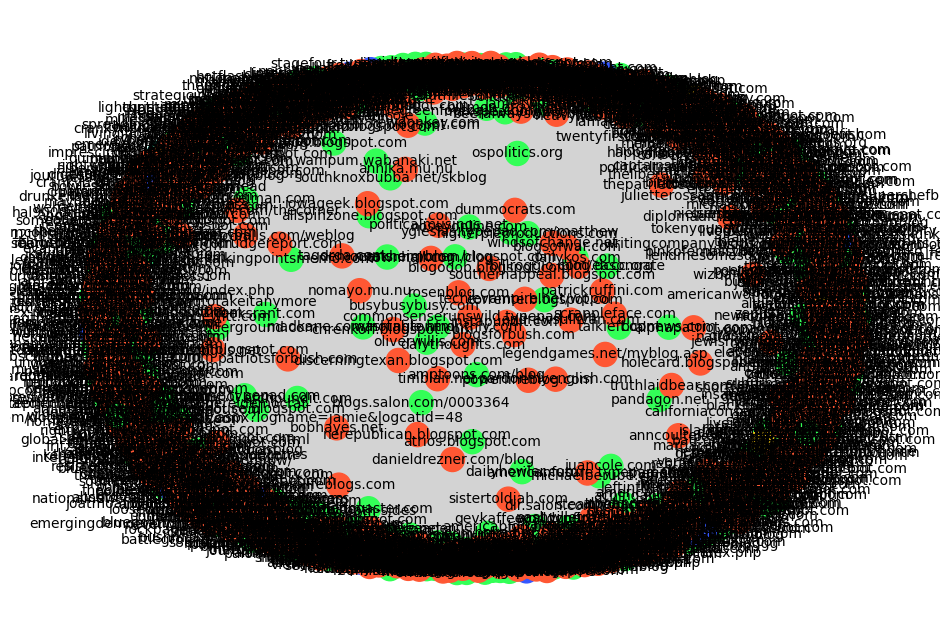

Adjusted Rand Index (ARI): 0.7750
Adjusted Mutual Information (AMI): 0.6419
Homogeneity Score (HS): 0.7459
Completeness Score (CS): 0.5666
F1 Score: 0.0361
Confusion Matrix:
[[ 30 520  26   1   3   0   2   2   2   0]
 [599  14  13   4   1   3   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]
Modularity Density: 0.2905
Community Score: 0.9204
Community Fitness: 0.9205
Normalized Mutual Information (NMI): 0.6440


In [22]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)
communities = algorithms.louvain(G).communities
community_dict_louvain = {i: community for i, community in enumerate(communities)}


for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#FF5733",  "#33FF57", "#3357FF", "#F1C40F","#8E44AD", "#E67E22", "#2ECC71", "#3498DB", "#E74C3C", "#1ABC9C", "#9B59B6", "#F39C12"]

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='lightgray')  # Aumenta la larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Riduci la dimensione delle etichette
plt.axis("off")
plt.show()

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_louvain = calcola_metriche(communities_dict, community_dict_louvain, adj_matrix_full)

# Leiden

Community 1: ['adamtalib.blogspot.com', 'buzzmachine.com', 'clarified.blogspot.com', 'democratvoice.org', 'elderbearden.blogspot.com', 'enemykombatant.blogspot.com', 'estropundit.blogspot.com', 'fuckthisblog.blogspot.com', 'ibe.blogspot.com', 'iwantmycountryback.org', 'jimtreacher.com', 'julietterossant.com/superchefblog/superchefblog.html', 'justmark.com', 'lawdork.blogspot.com', 'marcbrazeau.blogspot.com', 'mayflowerhill.blogspot.com', 'mysterypollster.com/main', 'nationalreview.com/frum/frum-diary.asp', 'oxblog.blogspot.com', 'penheaded.blogspot.com', 'pennywit.com/drupal', 'phoblographer.com', 'politics.feedster.com', 'pollsterseek.blogspot.com', 'praguewriter.typepad.com', 'qando.net', 'scripting.com', 'shotofpolitics.blogspot.com', 'steveguy.me.uk', 'strangesemantics.blogspot.com', 'theworldaroundyou.com', 'tomherod.blogspot.com', 'a100wwe.blogspot.com', 'absurd-canadian.blogspot.com', 'ace.mu.nu', 'aceoftrumpblog.blogspot.com', 'acepilots.com/mt', 'acertainslantoflight.blogspot.

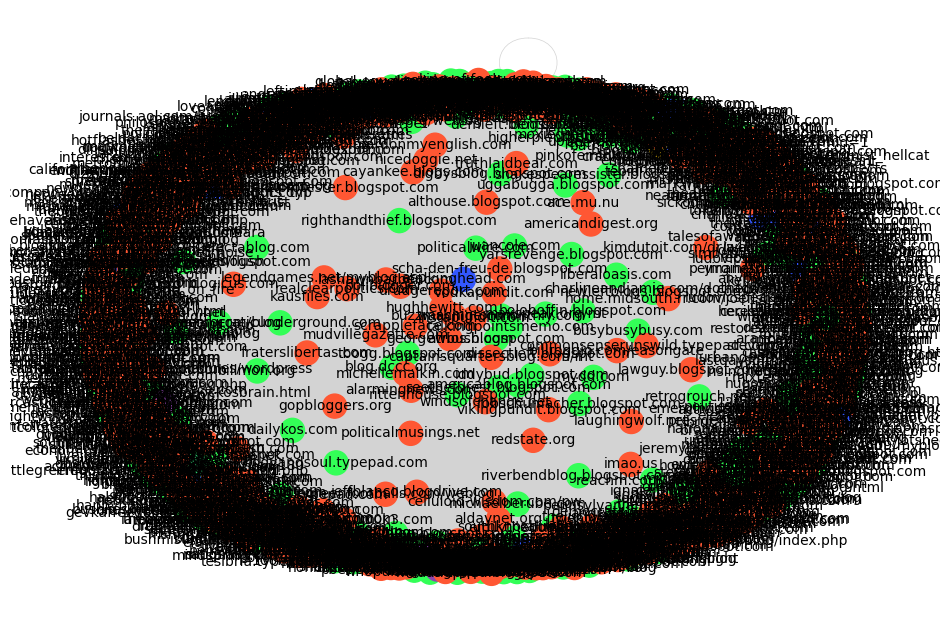

Adjusted Rand Index (ARI): 0.7679
Adjusted Mutual Information (AMI): 0.6382
Homogeneity Score (HS): 0.7364
Completeness Score (CS): 0.5661
F1 Score: 0.0386
Confusion Matrix:
[[ 32 518  28   1   0   3   2   2   0]
 [599  15  13   4   3   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]
Modularity Density: 0.2763
Community Score: 0.9204
Community Fitness: 0.9205
Normalized Mutual Information (NMI): 0.6401


In [23]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)

communities = algorithms.leiden(G).communities
community_dict_leiden = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#FF5733",  "#33FF57", "#3357FF", "#F1C40F","#8E44AD", "#E67E22", "#2ECC71", "#3498DB", "#E74C3C", "#1ABC9C", "#9B59B6", "#F39C12"]

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

# Disegna il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='lightgray')  # Aumenta la larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Riduci la dimensione delle etichette
plt.axis("off")
plt.show()

#Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_leiden = calcola_metriche(communities_dict, community_dict_leiden, adj_matrix_full)


# Risultati

                    Label Propagation    Louvain    Leiden
ARI                          0.791512   0.774975  0.767949
AMI                          0.680774   0.641941  0.638233
HS                           0.736500   0.745946  0.736359
CS                           0.636896   0.566558  0.566062
F1 Score                     0.045383   0.036136  0.038575
Modularity Density           0.382758   0.290485  0.276322
Community Score              0.926565   0.920403  0.920403
Community Fitness            0.926655   0.920493  0.920493
NMI                          0.683086   0.643993  0.640077
Numero di Comunità          11.000000  10.000000  9.000000


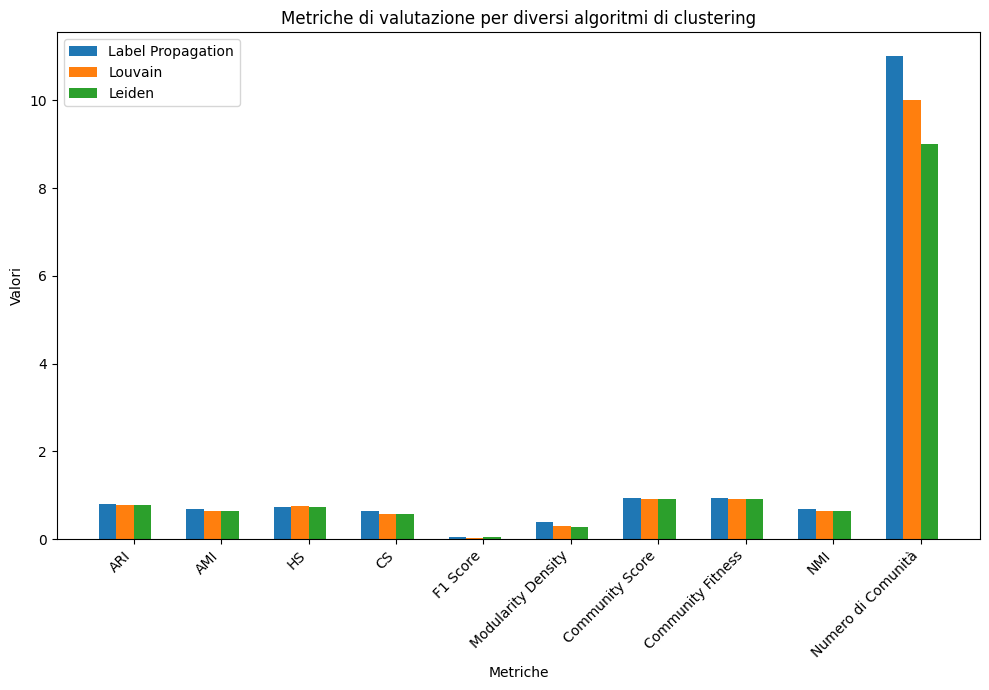

In [ ]:
# Aggiungi il numero delle comunità rilevate per ciascun algoritmo nei risultati
risultati = {
    "Label Propagation": {**risultati_label_propagation, "Numero di Comunità": len(community_dict_label_propagation)},
    "Louvain": {**risultati_louvain, "Numero di Comunità": len(community_dict_louvain)},
    "Leiden": {**risultati_leiden, "Numero di Comunità": len(community_dict_leiden)},
}

# Creazione di un DataFrame dalle metriche ottenute per ogni algoritmo, inclusi il numero di comunità
df_risultati = pd.DataFrame(risultati)

# Visualizzazione del DataFrame per vedere i risultati
print(df_risultati)

# Imposta dimensioni della figura per il grafico
fig, ax = plt.subplots(figsize=(10, 7))

# Definire le posizioni delle barre
n_misure = len(df_risultati.index)
bar_width = 0.2
index = np.arange(n_misure)

# Plot delle barre
for i, algoritmo in enumerate(df_risultati.columns):
    ax.bar(index + i * bar_width, df_risultati[algoritmo], bar_width, label=algoritmo)

# Aggiungere etichette e titolo
ax.set_xlabel('Metriche')
ax.set_ylabel('Valori')
ax.set_title('Metriche di valutazione per diversi algoritmi di clustering')

# Configurazione delle etichette per l'asse X
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(df_risultati.index, rotation=45, ha='right')

# Aggiungere legenda
ax.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()


# Conga tempo di implementazione dell'algoritmo troppo elevato (400min)

In [33]:
# Run the CONGA algorithm
subgraph_nodes = random.sample(list(G.nodes()), 200)  # Subgraph with 100 nodes
subgraph = G.subgraph(subgraph_nodes)

# Run CONGA on the subgraph
com = algorithms.conga(subgraph, number_communities=1)

community_dict = {i: community for i, community in enumerate(com.communities)}

# Print the detected communities
print("Communities detected:")
for i, community in enumerate(com.communities):
    print(f"Communità {i + 1}: {community}")

# Prepare for visualization
pos = nx.spring_layout(G, k=2)  # Layout for the nodes
colors = ["#FF5733",  "#33FF57", "#3357FF", "#F1C40F","#8E44AD", "#E67E22", "#2ECC71", "#3498DB", "#E74C3C", "#1ABC9C", "#9B59B6", "#F39C12"]

# Draw the graph with community coloring
plt.figure(figsize=(12, 8))
for community, color in zip(com.communities, colors):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=color, label=f"Community {com.communities.index(community) + 1}", node_size=500)

# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=1, edge_color='lightgray')
nx.draw_networkx_labels(G, pos, font_size=10)  # Dimensione ridotta delle etichette

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_conga = calcola_metriche(communities_dict, community_dict, adj_matrix_full)

KeyError: 1